In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as dates
import pylab

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from scipy import stats

from haversine import haversine
from datetime import datetime, date, timedelta
import json
import pickle

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

# A closer look at Waterloo Station

After a quick look it seems that Waterloo is among if not the busiest location. There are in fact 3 rental points for the station and 'Overview' shows that there are a massive number of bikes being taken from and returned to there each day.

For this notebook the three stations will be combined and treated as a single unit.

<table>
    <thead>
        <tr>
            <th>Name</th>
            <th>ID</th>
            <th>Capacity</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>Waterloo Station 1</td>
            <td>374</td>
            <td>36</td>
        </tr>
        <tr>
            <td>Waterloo Station 2</td>
            <td>361</td>
            <td>55</td>
        </tr>
        <tr>
            <td>Waterloo Station 3</td>
            <td>154</td>
            <td>35</td>
        </tr>
    </tbody>
    

</table>

In [2]:
d = pd.read_csv('tfl_cycle_hire_2017.csv')

In [3]:
waterloo_ids = [374, 361, 154]
d = d[(d['startstation_id'].isin(waterloo_ids)) | (d['endstation_id'].isin(waterloo_ids))]

In [4]:
d_copy = d.copy()

In [8]:
d = d_copy.copy()

In [9]:
d['returned'] = d['endstation_id'].isin(waterloo_ids)
d['startdate'] = pd.to_datetime(d['startdate'])
d['enddate'] = pd.to_datetime(d['enddate'])
# d.index = d['startdate']
# del d.index.name

In [10]:
print(d.shape)
d.head()

(332091, 19)


,startstation_lat,startstation_lon,startstaton_docks,endstation_lat,endstation_lon,endstationdocks,rental_id,duration,bike_id,startdate,startstation_id,startstation_name,enddate,endstation_id,endstation_name,year,startstation_location,endstation_location,returned
2433,51.513280,-0.047784,33,51.504027,-0.113864,36,64050784,1320,6623,2017-04-14 05:49:00,483,"Albert Gardens, Stepney",2017-04-14 06:11:00,374,"Waterloo Station 1, Waterloo",2017,POINT(-0.047784 51.51328),POINT(-0.113864 51.504027),True
2434,51.513280,-0.047784,33,51.504027,-0.113864,36,66945617,2040,10353,2017-07-05 09:12:00,483,"Albert Gardens, Stepney",2017-07-05 09:46:00,374,"Waterloo Station 1, Waterloo",2017,POINT(-0.047784 51.51328),POINT(-0.113864 51.504027),True
2435,51.513280,-0.047784,33,51.503919,-0.113426,55,64596695,1260,4446,2017-05-02 18:24:00,483,"Albert Gardens, Stepney",2017-05-02 18:45:00,361,"Waterloo Station 2, Waterloo",2017,POINT(-0.047784 51.51328),POINT(-0.113426 51.503919),True
5180,51.494347,-0.215804,33,51.504027,-0.113864,36,63268877,1860,6887,2017-03-21 16:13:00,634,"Brook Green South, Brook Green",2017-03-21 16:44:00,374,"Waterloo Station 1, Waterloo",2017,POINT(-0.215804 51.494347),POINT(-0.113864 51.504027),True
5181,51.494347,-0.215804,33,51.503791,-0.112824,35,62422002,1920,833,2017-02-16 16:03:00,634,"Brook Green South, Brook Green",2017-02-16 16:35:00,154,"Waterloo Station 3, Waterloo",2017,POINT(-0.215804 51.494347),POINT(-0.112824 51.503791),True


So, when are people taking and returning these things. The assumption is that the traffic is massively commuter-heavy.

Well, looks like this is true, Overwhelming number removed are in the morning hours and similarly most are returned at going-home time.

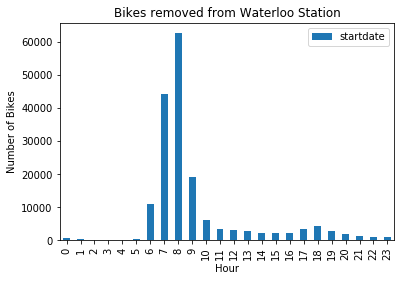

In [11]:
ax = pd.DataFrame(d[d['returned'] == False].startdate.dt.hour.value_counts()).sort_index().plot(kind='bar', title="Bikes removed from Waterloo Station")
ax.set(xlabel='Hour', ylabel='Number of Bikes')
plt.show()

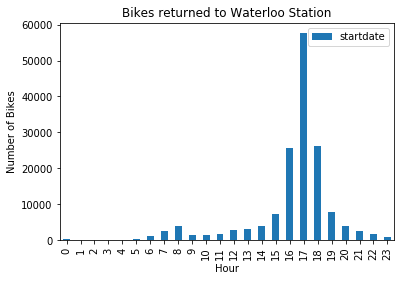

In [12]:
ax = pd.DataFrame(d[d['returned'] == True].startdate.dt.hour.value_counts()).sort_index().plot(kind='bar', title="Bikes returned to Waterloo Station")
ax.set(xlabel='Hour', ylabel='Number of Bikes')
plt.show()

There really is not much usage on the weekend.

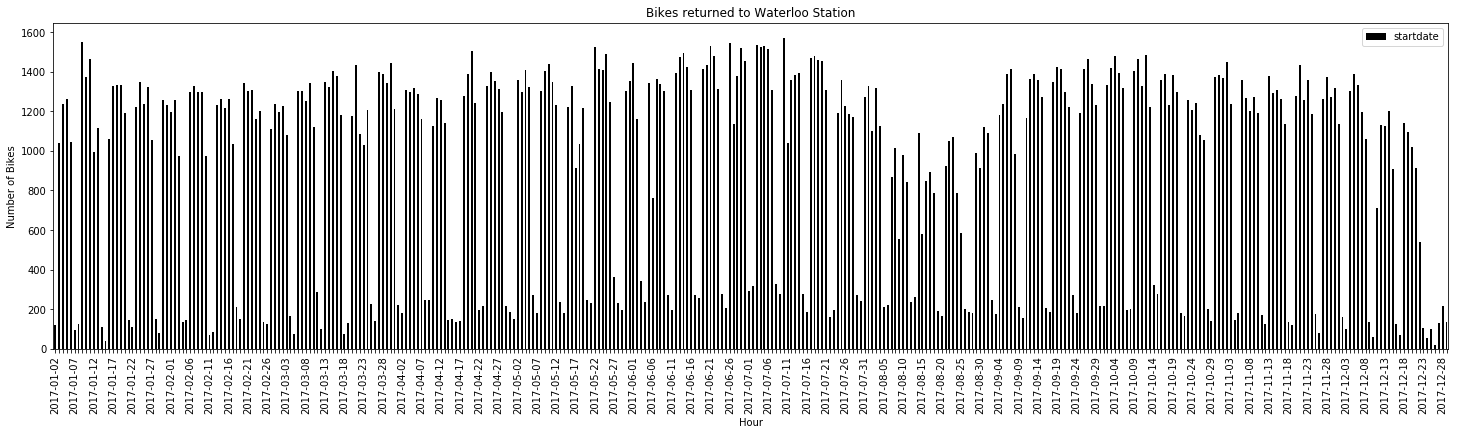

In [31]:
ax = pd.DataFrame(d.startdate.dt.date.value_counts()).sort_index().plot(kind='bar', title="Bikes returned to Waterloo Station", color='black', figsize=[25,6])
ax.set(xlabel='Hour', ylabel='Number of Bikes') 
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % 5 != 0:
        label.set_visible(False)
plt.show()

What does daily usage look like if we only look at weekdays. Seems fairly consistent across the year.

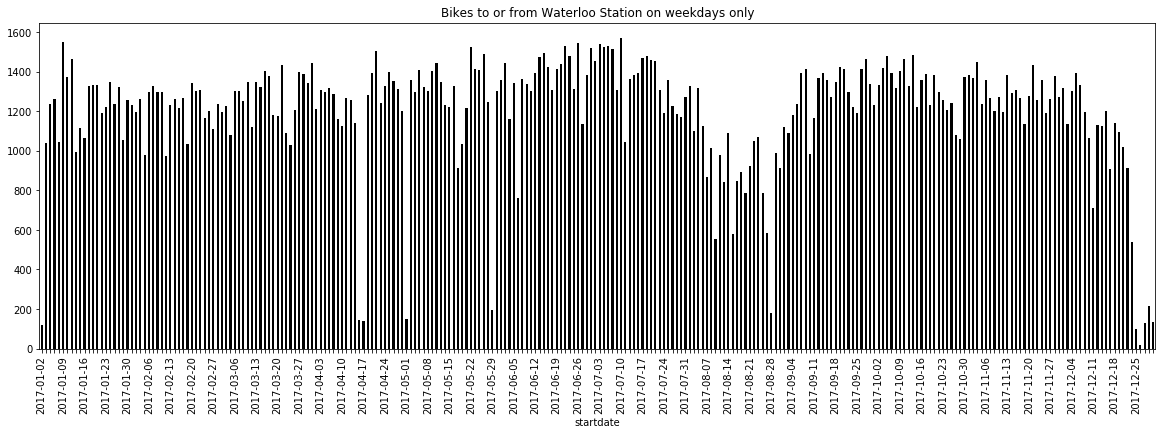

In [33]:
fig, ax = plt.subplots()
d[d['startdate'].dt.dayofweek <= 4].groupby(d['startdate'].dt.date)['startstation_id'].count().plot(ax=ax, kind="bar", color='black', figsize=[20,6], title="Bikes to or from Waterloo Station on weekdays only") 
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % 5 != 0:
        label.set_visible(False)

## Get some general numbers
For each day, we can record the number taken and returned, as well as the net loss or gain in bikes for the day and the ratio for taken:returned.

We will here define 'used' as either taken or returned, basically meaning that the bike had some sort of transaction with Waterloo.

In [20]:
total_returned = pd.DataFrame(d.groupby([d.startdate.dt.date]).sum()['returned']).reset_index()

total_used = pd.DataFrame(d.groupby([d.startdate.dt.date]).count()['returned']).reset_index()
total_used.columns = ['startdate', 'used']

totals = pd.merge(total_used, total_returned, on="startdate")
totals['startdate'] = pd.to_datetime(totals.startdate)
totals['net_loss'] = totals.used - 2 * totals.returned
totals['returned_ratio'] = totals.returned / totals.used
totals['taken'] = totals.used - totals.returned
totals.head(10)

,startdate,used,returned,net_loss,returned_ratio,taken
0,2017-01-02,121,74.0,-27.0,0.611570,47.0
1,2017-01-03,1041,544.0,-47.0,0.522574,497.0
2,2017-01-04,1234,607.0,20.0,0.491896,627.0
3,2017-01-05,1261,627.0,7.0,0.497224,634.0
4,2017-01-06,1046,440.0,166.0,0.420650,606.0
5,2017-01-07,97,50.0,-3.0,0.515464,47.0
6,2017-01-08,123,63.0,-3.0,0.512195,60.0
7,2017-01-09,1551,748.0,55.0,0.482270,803.0
8,2017-01-10,1373,684.0,5.0,0.498179,689.0
9,2017-01-11,1463,703.0,57.0,0.480519,760.0


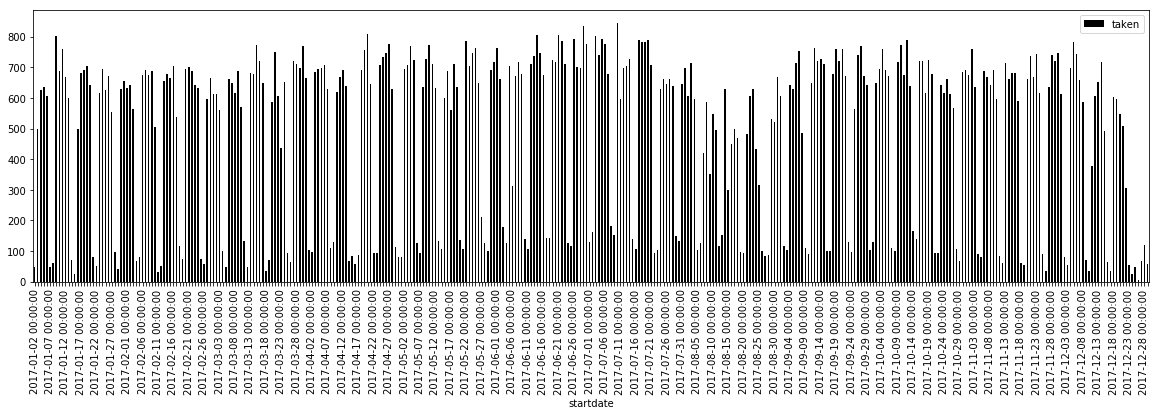

In [30]:
ax = totals.plot('startdate', 'taken', kind='bar', color='black', figsize=[20,5])
for index, label in enumerate(ax.xaxis.get_ticklabels()):
    if index % 5 != 0:
        label.set_visible(False)

Lets look a bit more generally, by week and month, creating a dataframe similar to the general one above.

In [35]:
total_returned = pd.DataFrame(d.groupby([d.startdate.dt.week]).sum()['returned']).reset_index()

total_used = pd.DataFrame(d.groupby([d.startdate.dt.week]).count()['returned']).reset_index()
total_used.columns = ['startdate', 'used']

totals_week = pd.merge(total_used, total_returned, on="startdate")
totals_week['net_loss'] = totals_week.used - 2 * totals_week.returned
totals_week['returned_ratio'] = totals_week.returned / totals_week.used
totals_week['taken'] = totals_week.used - totals_week.returned
totals_week.head(10)

,startdate,used,returned,net_loss,returned_ratio,taken
0,1,4923,2405.0,113.0,0.488523,2518.0
1,2,6649,3031.0,587.0,0.455858,3618.0
2,3,6498,3151.0,196.0,0.484918,3347.0
3,4,6410,3113.0,184.0,0.485647,3297.0
4,5,6196,2927.0,342.0,0.472402,3269.0
5,6,6343,3024.0,295.0,0.476746,3319.0
6,7,6370,2940.0,490.0,0.461538,3430.0
7,8,6574,3081.0,412.0,0.468664,3493.0
8,9,6087,2892.0,303.0,0.475111,3195.0
9,10,6709,3343.0,23.0,0.498286,3366.0


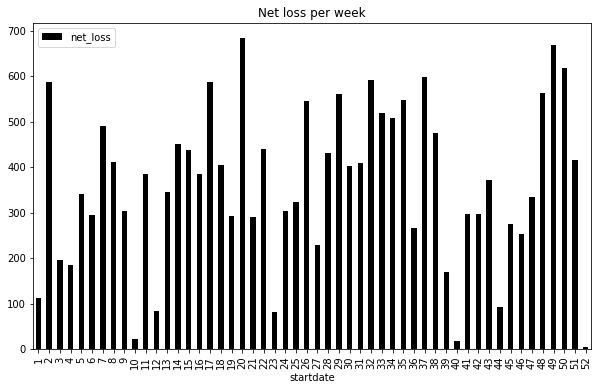

In [37]:
totals_week.plot('startdate', 'net_loss', kind='bar', color='black', figsize=[10,6], title="Net loss per week")

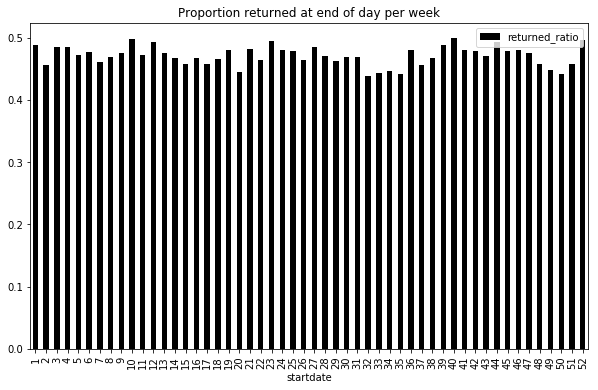

In [39]:
totals_week.plot('startdate', 'returned_ratio', kind='bar', color='black', figsize=[10,6], title="Proportion returned at end of day per week")

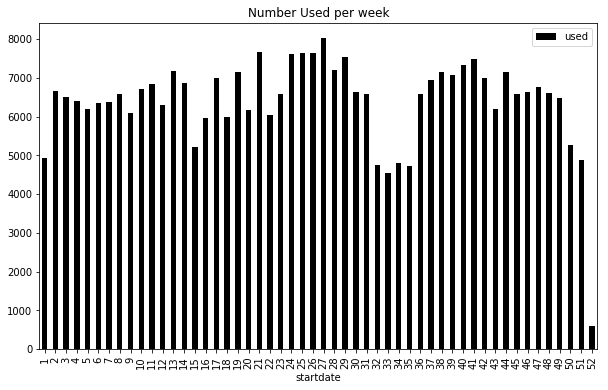

In [40]:
totals_week.plot('startdate', 'used', kind='bar', color='black', figsize=[10,6], title="Number Used per week")

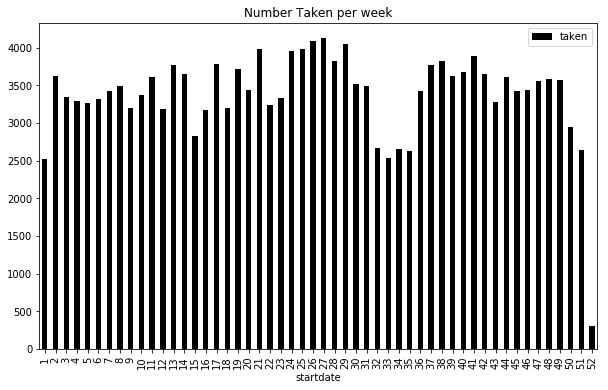

In [41]:
totals_week.plot('startdate', 'taken', kind='bar', color='black', figsize=[10,6], title="Number Taken per week")

In [43]:
total_returned = pd.DataFrame(d.groupby([d.startdate.dt.month]).sum()['returned']).reset_index()

total_used = pd.DataFrame(d.groupby([d.startdate.dt.month]).count()['returned']).reset_index()
total_used.columns = ['startdate', 'used']

totals_month = pd.merge(total_used, total_returned, on="startdate")
totals_month['net_loss'] = totals_month.used - 2 * totals_month.returned
totals_month['returned_ratio'] = totals_month.returned / totals_month.used
totals_month['taken'] = totals_month.used - totals_month.returned
totals_month.head(10)

,startdate,used,returned,net_loss,returned_ratio,taken
0,1,26968,12904.0,1160.0,0.478493,14064.0
1,2,25341,11853.0,1635.0,0.467740,13488.0
2,3,30361,14703.0,955.0,0.484273,15658.0
3,4,25426,11779.0,1868.0,0.463266,13647.0
4,5,29835,14002.0,1831.0,0.469315,15833.0
5,6,32046,15246.0,1554.0,0.475754,16800.0
6,7,31275,14828.0,1619.0,0.474117,16447.0
7,8,22606,10092.0,2422.0,0.446430,12514.0
8,9,29048,13724.0,1600.0,0.472459,15324.0
9,10,30983,14981.0,1021.0,0.483523,16002.0


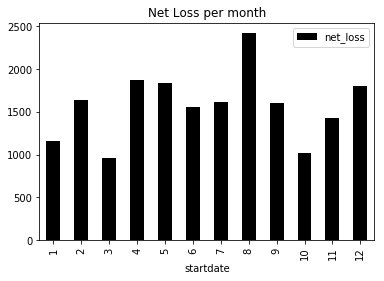

In [44]:
totals_month.plot('startdate', 'net_loss', kind='bar', color='black', title="Net Loss per month")

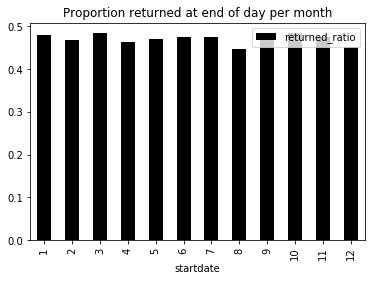

In [45]:
totals_month.plot('startdate', 'returned_ratio', kind='bar', color='black', title="Proportion returned at end of day per month")

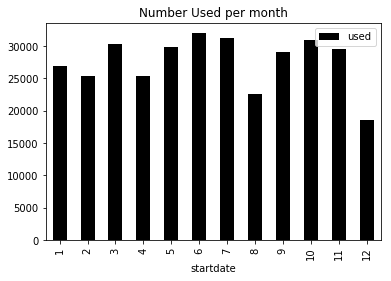

In [46]:
totals_month.plot('startdate', 'used', kind='bar', color='black', title="Number Used per month")

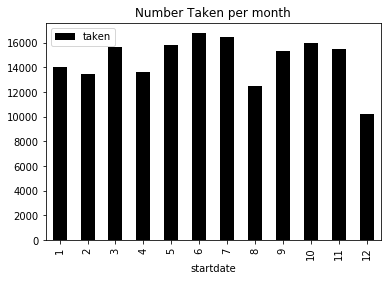

In [47]:
totals_month.plot('startdate', 'taken', kind='bar', color='black', title="Number Taken per month")

## Wouldn't it be nice to predict something useful?

One of the obvious problems operationally for a cycle hire scheme is making sure that there are bikes in the right places. Both so you can pick one up, and so there is space to leave one behind.

Unfortunately TFL don't give out any historical data for bike-point capacity (although there is an API for that). We can however do some quick and dirty fun as seen in 'Overview' to see whether it looks like somewhere has been replaced or emptied during some single day. We saw how this very definitely happened for Waterloo and it raises the question of how many bikes do you actually need to move, and how to you predict this.

This station is huge, and demand is pretty consistent, so it makes some sense that they would want to have a local warehouse of some sort (assuming that the land is available) instead of constantly shipping in and our - you would collect all the bikes in the evening and gradually put them back out in the morning. However, what if demand tomorrow isn't like today? There's no point having a few hundred bikes sitting in a warehouse when they could be useful eg in Soho.

We will try to build a basic model to predict the demand for a given day, the assumption being that by the evening you have an idea of today's data and want to see if tomorrow you will need bikes in Waterloo or elsewhere.

This will be a fairly simple multiple linear regression model. The three variables we will use are the bikes taken from one week ago, the bikes taken from the last day of the same type (eg the last business day if tomorrow is a business day), and a binary variable for whether it is a working day or not (not weekend or bank holiday.)

In [48]:
used = totals[['startdate', 'used']].copy()
used.columns = ['date', 'total']
used_original = used.copy()
used.head()

,date,total
0,2017-01-02,121
1,2017-01-03,1041
2,2017-01-04,1234
3,2017-01-05,1261
4,2017-01-06,1046


#### Same day last week

In [54]:
used['total_last_week'] = used['total'].shift(7)
used = used[~used['total_last_week'].isnull()]
used.head(10)

,date,total,total_last_week
7,2017-01-09,1551,121.0
8,2017-01-10,1373,1041.0
9,2017-01-11,1463,1234.0
10,2017-01-12,993,1261.0
11,2017-01-13,1117,1046.0
12,2017-01-14,112,97.0
13,2017-01-15,40,123.0
14,2017-01-16,1062,1551.0
15,2017-01-17,1328,1373.0
16,2017-01-18,1331,1463.0


r^2 for same day last week vs current:  0.8576193580805839


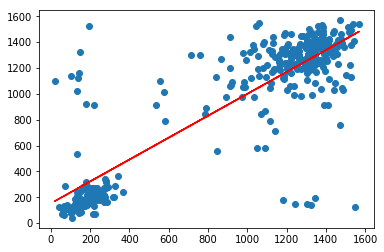

In [58]:
slope, intercept, r_value, p_value, std_err = stats.linregress(used.total, used.total_last_week)
print(f'r^2 for same day last week vs current:  {r_value}')
pylab.scatter(used.total, used.total_last_week)
plt.plot(used.total, intercept + slope * used.total, 'r')
plt.show()

### Days off - Bank Holidays and Weekends

Days when people have a day off work.

Would be nice to predict holiday times too but not sure how to do so reliably. School holidays?

In [59]:
holidays = []
with open('bank_holidays_2017.csv', 'r') as f:
    for line in f:
        holidays.append(datetime.strptime(line.strip('\n'), '%d/%m/%y'))
    
used['day_off'] = used['date'].apply(lambda d: (d in holidays) | (d.dayofweek >= 5) )

### Previous day of same day-type (eg previous day working  if working)

#### Weekdays
Excluding bank holidays

In [60]:
weekdays = used_original[(used_original.date.dt.dayofweek <= 4) & (~used_original['date'].isin(holidays))].copy()
weekdays['date'] = weekdays['date'].shift(1)
print('shape', weekdays.shape)
weekdays.head()

shape (254, 2)


,date,total
1,NaT,1041
2,2017-01-03,1234
3,2017-01-04,1261
4,2017-01-05,1046
7,2017-01-06,1551


r^2 for previous weekday:  0.605509737983169


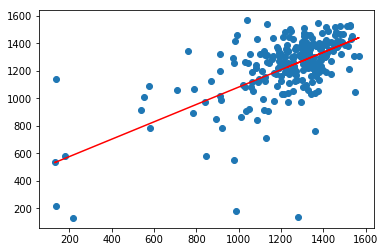

In [61]:
slope, intercept, r_value, p_value, std_err = stats.linregress(weekdays.total[:-1], weekdays.total[1:])
print(f'r^2 for previous weekday:  {r_value}')
pylab.scatter(weekdays.total[1:], weekdays.total[:-1])
plt.plot(weekdays.total[1:], intercept + slope * weekdays.total[1:], 'r')
plt.show()

#### Weekends
\+ bank holidays

In [62]:
weekends = used_original[(used_original.date.dt.dayofweek >= 5) | (used_original['date'].isin(holidays))].copy()
weekends['date'] = weekends['date'].shift(1)
print('shape', weekends.shape)
weekends.head()

shape (108, 2)


,date,total
0,NaT,121
5,2017-01-02,97
6,2017-01-07,123
12,2017-01-08,112
13,2017-01-14,40


r^2 for previous weekend day:  0.539578967100243


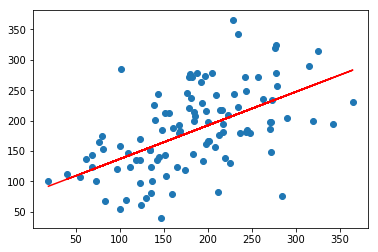

In [63]:
slope, intercept, r_value, p_value, std_err = stats.linregress(weekends.total[:-1], weekends.total[1:])
print(f'r^2 for previous weekend day:  {r_value}')
pylab.scatter(weekends.total[1:], weekends.total[:-1])
plt.plot(weekends.total[1:], intercept + slope * weekends.total[1:], 'r')
plt.show()

Combine the two and merge into main

In [64]:
last_day_type = pd.concat([weekends, weekdays], sort=True).sort_values(by='date')
last_day_type.columns = ['date', 'total_last_same_day_type']
last_day_type = last_day_type[~last_day_type['date'].isnull()]
last_day_type.head()

,date,total_last_same_day_type
5,2017-01-02,97
2,2017-01-03,1234
3,2017-01-04,1261
4,2017-01-05,1046
7,2017-01-06,1551


In [65]:
used = pd.merge(used, last_day_type, on='date')
used.head()

,date,total,total_last_week,day_off,total_last_same_day_type
0,2017-01-09,1551,121.0,False,1373
1,2017-01-10,1373,1041.0,False,1463
2,2017-01-11,1463,1234.0,False,993
3,2017-01-12,993,1261.0,False,1117
4,2017-01-13,1117,1046.0,False,1062


### Cool, Lets have a look at what we have

We can quickly plot our predictors before we mix them all together

In [211]:
used.to_pickle('used.pkl')

In [ ]:
used = pd.from_pickle('used.pkl')

In [66]:
used.head()

,date,total,total_last_week,day_off,total_last_same_day_type
0,2017-01-09,1551,121.0,False,1373
1,2017-01-10,1373,1041.0,False,1463
2,2017-01-11,1463,1234.0,False,993
3,2017-01-12,993,1261.0,False,1117
4,2017-01-13,1117,1046.0,False,1062


r^2 for same day last week:  0.8632322346164296


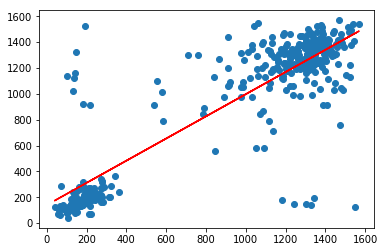

In [215]:
slope, intercept, r_value, p_value, std_err = stats.linregress(used.total, used.total_last_week)
print(f'r^2 for same day last week:  {r_value}')
pylab.scatter(used.total, used.total_last_week)
plt.plot(used.total, intercept + slope * used.total, 'r')
plt.show()

r^2 for last of same day type:  0.9421511114738644


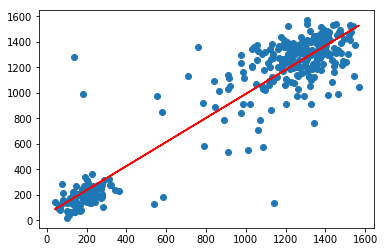

In [216]:
slope, intercept, r_value, p_value, std_err = stats.linregress(used.total, used.total_last_same_day_type)
print(f'r^2 for last of same day type:  {r_value}')
pylab.scatter(used.total, used.total_last_same_day_type)
plt.plot(used.total, intercept + slope * used.total, 'r')
plt.show()

r^2 for last of same day type:  -0.9256384168523355


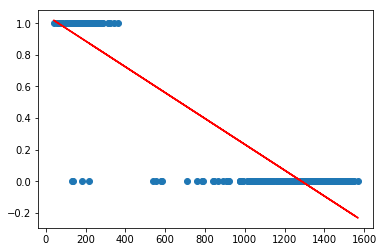

In [217]:
slope, intercept, r_value, p_value, std_err = stats.linregress(used.total, used.day_off)
print(f'r^2 for last of same day type:  {r_value}')
pylab.scatter(used.total, used.day_off)
plt.plot(used.total, intercept + slope * used.total, 'r')
plt.show()

Not too bad in general

Now lets split it into training and test sets and model it up!

In [68]:
used.head()

,date,total,total_last_week,day_off,total_last_same_day_type
0,2017-01-09,1551,121.0,False,1373
1,2017-01-10,1373,1041.0,False,1463
2,2017-01-11,1463,1234.0,False,993
3,2017-01-12,993,1261.0,False,1117
4,2017-01-13,1117,1046.0,False,1062


In [67]:
X = used[['total_last_week', 'total_last_same_day_type', 'day_off']]
y = used['total']

In [92]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33)

In [93]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
print(f'Intercept:    {regr.intercept_}')
print(f'Coefficients: {regr.coef_}')

Intercept:    528.2352832146678
Coefficients: [ 1.06757223e-01  4.63611043e-01 -4.55101476e+02]


In [94]:
y_predicted = regr.predict(X_test)

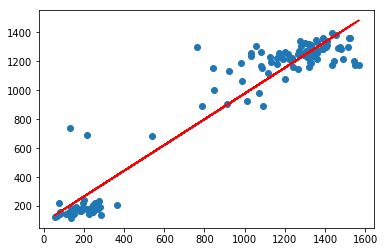

Score:  0.917167987844442


In [102]:
slope, intercept, r_value, p_value, std_err = stats.linregress(y_test, y_predicted)
pylab.scatter(y_test, y_predicted)
plt.plot(y_test, intercept + slope * y_test, 'r')
plt.show()
print(f'Score:  {regr.score(X_test, y_test)}')

## How did we do?

So, all in all not too bad. Definitely improved on any single predictor though it's absolutely not perfect.

### Improvements

Other predictors that could be interesting to look at include:

* Weather - did it/is it predicted to rain and does this affect people's decisions.
* Holiday times - Unclear how best to represent this, maybe finding some dataset of most common holiday times or correlating to school holidays.
  * This could be binary as in the 'days_off' property or weighted based on when people actually take holidays.
* Darkness - Do fewer people tend to cycle in the dark. In December it gets light some time after 8AM and dark around 4PM, meaning many people would be coming home in the dark.
  * However the week/month views don't really suggest a reduction of people in December.
* Better modelling of a week prior. This works well for stable schedules but less well if we are looking at a business day a week after a bank holiday.
  * We could change the creation of this to go further back in the case of a confict, or add a second binary variable.
* Rolling average for the past n days rather than just the day before.